In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [22]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [23]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [28]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        for p in self.parameters():
            print ("P=", p.shape) 
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [29]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

P= torch.Size([128, 784])
P= torch.Size([128])
P= torch.Size([16, 128])
P= torch.Size([16])
P= torch.Size([128, 16])
P= torch.Size([128])
P= torch.Size([784, 128])
P= torch.Size([784])
P= torch.Size([128, 784])
P= torch.Size([128])
P= torch.Size([32, 128])
P= torch.Size([32])
P= torch.Size([128, 32])
P= torch.Size([128])
P= torch.Size([784, 128])
P= torch.Size([784])
P= torch.Size([128, 784])
P= torch.Size([128])
P= torch.Size([64, 128])
P= torch.Size([64])
P= torch.Size([128, 64])
P= torch.Size([128])
P= torch.Size([784, 128])
P= torch.Size([784])


In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [9]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.950156 32: 0.944451 64: 0.954872
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.494585 32: 0.410932 64: 0.363441
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.322949 32: 0.303841 64: 0.291475
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.293484 32: 0.286357 64: 0.279696
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.277548 32: 0.274643 64: 0.270480
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.263719 32: 0.261386 64: 0.258360
Test set:
16: loss: 0.2741	pho_loss: 0.0040
32: loss: 0.2718	pho_loss: 0.0041
64: loss: 0.2688	pho_loss: 0.0041

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.259105 32: 0.256843 64: 0.253887
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.271851 32: 0.270358 64: 0.268136
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.257011 32: 0.256414 64: 0.255971
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.268861 32: 0.268531 64: 0.267780
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.275644 32: 0.276455 64: 0.276577
Train

Test set:
16: loss: 0.1398	pho_loss: 0.0040
32: loss: 0.1229	pho_loss: 0.0040
64: loss: 0.1113	pho_loss: 0.0040

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.134859 32: 0.116327 64: 0.105376
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.133413 32: 0.119883 64: 0.105408
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.136222 32: 0.119121 64: 0.107225
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.142041 32: 0.123541 64: 0.110505
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.123964 32: 0.108318 64: 0.096810
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.133220 32: 0.117436 64: 0.104380
Test set:
16: loss: 0.1350	pho_loss: 0.0040
32: loss: 0.1180	pho_loss: 0.0040
64: loss: 0.1051	pho_loss: 0.0040

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.136317 32: 0.119246 64: 0.107079
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.124447 32: 0.109833 64: 0.096807
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.128935 32: 0.112254 64: 0.100209
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

In [11]:
torch.save(models['64'], './model_64_kl')


/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [10]:
model = torch.load('./model_64_kl')

In [11]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 6,  3,  4,  6,  6,  4,  2,  2,  4,  5,  7,  0,  3,  6,
         6,  2,  7,  5,  4,  5,  5,  5,  4,  3,  2,  4,  6,  6,
         5,  6,  5,  6,  6,  2,  7,  4,  1,  6,  0,  4,  6,  2,
         6,  2,  4,  4,  6,  3,  4,  6])


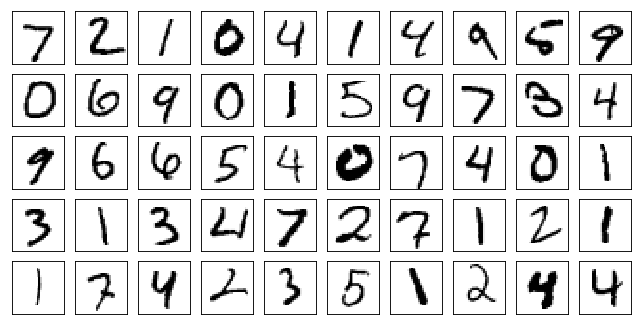

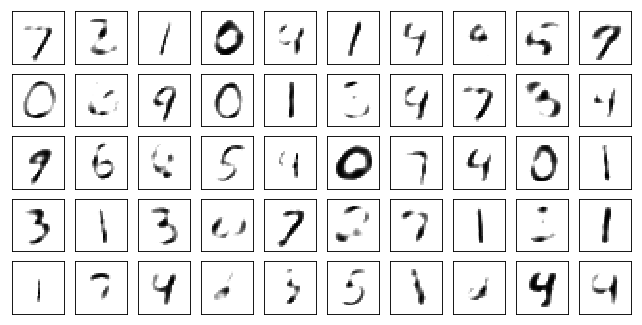

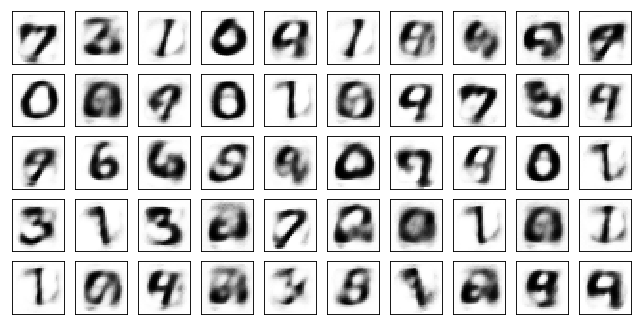

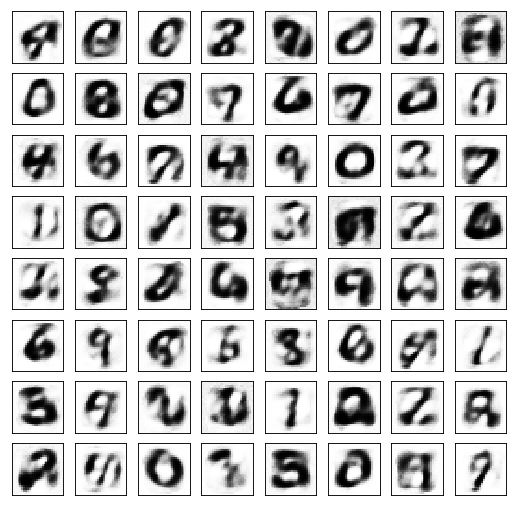

In [12]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

### Генерация новых изображений


In [35]:
gen, _ = next(iter(test_loader))

In [36]:
gen_vec = gen.view(-1, 28*28)

In [38]:
print(gen_vec.shape)

torch.Size([1, 39200])


In [42]:
train_size = len(train_loader.sampler)
for batch_idx, (data, _) in enumerate(train_loader):
    w_optim.zero_grad()
    t = model.E(w.view(-1, 28*28))
    w_loss = F.mse_loss(t, torch.eye(64))
    w_loss.backward()
    w_optim.step()
            
    if batch_idx % 200 == 0:
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

NameError: name 'w_optim' is not defined

In [136]:
class Generator(nn.Module):
    def __init__(self, encoder, latent_size=10, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Generator, self).__init__()
        self.encoder = encoder
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 28*28)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        self._loss = None
        self.latent_size = latent_size
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)       
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss 

In [137]:
generator = Generator(encoder=model.E, latent_size=64)

In [140]:
def train_generator(epoch):
    loss_stats = np.empty((1))

    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
              
        generator.optim.zero_grad()
        output = generator.forward(data)
        output_encoded = generator.encoder(output)
        print ("output=", output.shape)
        print ("output_enc=", output_encoded.shape)
        
        latent_vector = torch.eye(generator.latent_size)
        print ("latent_vec=", latent_vector.shape)
        
        loss = generator.loss(output_encoded, latent_vector)
        loss.backward()
        generator.optim.step()                

        if batch_idx % 200 == 0:
            print_stats(models, train_loader, epoch, batch_idx, data, train_size)            
            stats_line = [generator._loss]        
            loss_stats = np.vstack([loss_stats, stats_line])

    else:
        batch_idx += 1
        print_stats(models, train_loader, epoch, batch_idx, data, train_size)
        stats_line = [generator._loss]
        loss_stats = np.vstack([loss_stats, stats_line])

    epoch_loss = np.mean(loss_stats, axis=0)      
    return epoch_loss

def print_stats(models, train_loader, epoch, batch_idx, data, train_size):
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = '{:.6f}'.format(generator._loss)
    print(line + losses)
        


In [141]:
for epoch in range(1, 21):
    generator.train()
    train_generator(epoch)

output= torch.Size([50, 784])
output_enc= torch.Size([50, 64])
latent_vec= torch.Size([64, 64])


ValueError: Expected input batch_size (50) to match target batch_size (64).